In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot
from sklearn import linear_model

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_white , normal_ad

C:\Users\user\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
HOME_DIR = Path.cwd()
DATA_DIR = Path(HOME_DIR, "data")
data = pd.read_csv(Path(DATA_DIR, "billets.csv"), sep=";")
data.shape

(1500, 7)

In [3]:
data_model = data.loc[lambda dfr: dfr.margin_low.notnull()]

In [4]:
X = data_model.loc[:, ["diagonal", "height_left", "height_right", "margin_up", "length"]] 
y = data_model.loc[:, 'margin_low']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
std_scaler = StandardScaler().fit(X_train) 
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

# Regression

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
# On crée un modèle de régression linéaire
lr = linear_model.LinearRegression()

# On entraîne ce modèle sur les données d'entrainement
lr.fit(X_train_std, y_train)

# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
lr_error = mean_squared_error(y_test,lr.predict(X_test_std))
y_pred_test = lr.predict(X_test_std)
r2_score_test = r2_score(y_test, y_pred_test)

# On obtient l'erreur quadratique ci-dessous
print(lr_error)
print(r2_score_test)

0.21624524016354504
0.4935293486623853


In [9]:
print("Intercept:", lr.intercept_)
print("Coefficients:", lr.coef_)

Intercept: 4.484804687499997
Coefficients: [-0.02645544  0.05304223  0.08501514  0.06652093 -0.3533451 ]


In [10]:
# Check for Multicollinearity
# Variance Inflation Factor (VIF)
r_square_test = metrics.mean_squared_error(y_test, lr.predict(X_test_std), squared=True)
vif = 1 / (1 - r_square_test)
vif

1.2759093165937119

# Exercice 1

In [19]:
def train_model(model, x_train, y_train, x_test, y_test):
    # On entraîne ce modèle sur les données d'entrainement
    model.fit(x_train, y_train)
    
    # On récupère l'erreur de norme 2 sur le jeu de données train
    error_train = np.mean((model.predict(x_train) - y_train) ** 2)

    # On récupère l'erreur de norme 2 sur le jeu de données test
    error_test = np.mean((model.predict(x_test) - y_test) ** 2)

    # On obtient l'erreur quadratique ci-dessous
    print(f"Model error: {round(error_test, 5)}")
    return {"estimator": model, "error_train": error_train, "error_test": error_test}

In [20]:
# Train and evaluate Elastic Net regression
elastic_error = train_model(model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5),
                            x_train=X_train_std, y_train=y_train,
                            x_test=X_test, y_test=y_test)

Model error: 0.42698


C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


Dans la cellule précédente, veuillez analyser les variables explicatives: que constatez vous entre le jeu de train et le jeu de test?

In [32]:
error_test = elastic_error["error_test"]
error_train = elastic_error["error_train"]
coef = elastic_error["estimator"]

In [37]:
print(f"Error test : {error_test}")
print(f"Error train : {error_train}")
print(X_train.columns)
print(coef.coef_)

Error test : 0.42698000593598173
Error train : 0.4460780868530273
Index(['diagonal', 'height_left', 'height_right', 'margin_up', 'length'], dtype='object')
[-0.  0.  0.  0. -0.]


Le modèle Elastic Net a attribué des coefficients quasi nuls aux variables, ce qui indique une faible pertinence de ces dernières pour le modèle. Cela suggére que les variables explicatives ne fournissent pas suffisamment d’information pour bien prédire la variable cible. Cependant, il est également possible que les paramètres choisis pour Elastic Net (alpha = 1 et l1_ratio = 0.5) soient sous-optimaux. Une recherche d'hyperparamètres plus exhaustive pourrait révéler des valeurs de coefficients non nulles si les variables ont effectivement une certaine utilité prédictive.

L'autre constat qu'on pourrait dégager avec ces résultats, c'est que l'erreur sur l'échantillon d'entrainement est plus élevée que celle sur l'échantillon de test ce qui peut indiquer un phénomène de sous-apprentissage, où le modèle est trop simple pour capter les relations dans les données. Cela pourrait être dû à un alpha trop élevé qui empêche le modèle de s'adapter suffisamment aux données d’entraînement. Une optimisation des paramètres pourrait également réduire cet écart.

# Exercice 2

Nous avons observé avec les résultats précedents que l'erreur sur l'échantillon est élevée avec un score (R2) de seulement 49.35%, de plus le teste de multicolinéarité entre les variables explicatives montre une corrélation modérée entre ces dernière. Le but de l'exo est donc d'optimiser les models de ridge, lasso et ElasticNet pour améliorer le modèle.

## Modèle de ridge

Ici l'idée est de jouer sur le coéfficient alpha du modèle de ridge pour optimiser son résultat

In [11]:
from sklearn.linear_model import Ridge

In [39]:
# On crée un modèle de régression linéaire
ridge = linear_model.Ridge(alpha=1)

# On entraîne ce modèle sur les données d'entrainement
ridge.fit(X_train_std, y_train)

# On récupère l'erreur de norme 2 sur le jeu de données test
ridge_error = mean_squared_error(y_test,ridge.predict(X_test_std))
score_test = r2_score(y_test,ridge.predict(X_test_std))


# On obtient l'erreur quadratique ci-dessous
print(f"error test : {ridge_error}")
print(f"Score : {score_test}")

error test : 0.21625274624371824
Score : 0.49351176857918244


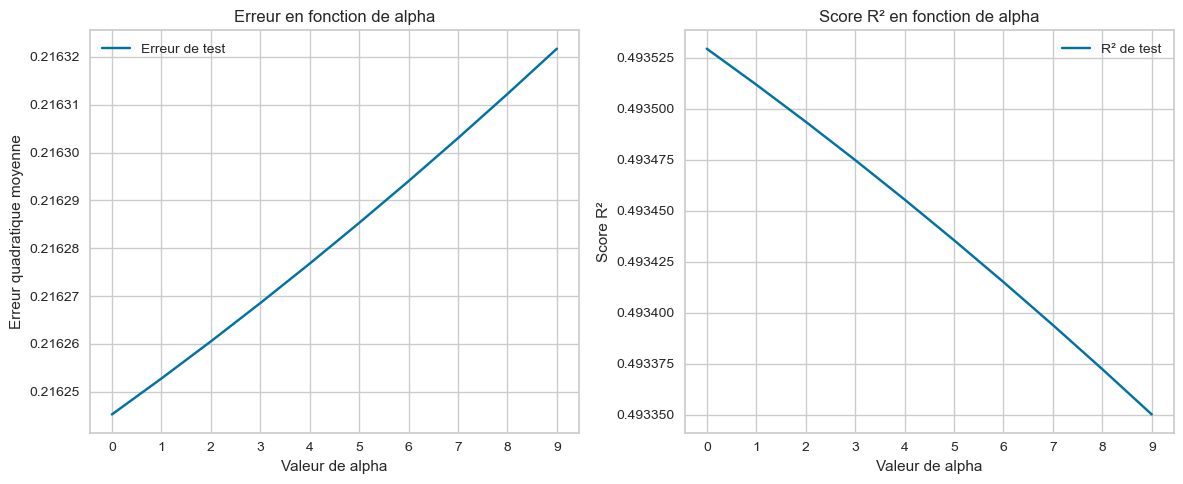

In [13]:
#Nous allons faire un graphe pour voir l'évolution de l'error et du score (R2) du modèle de ridge suivant des valeurs de alpha

alpha_values = np.arange(0,10)
train_errors = []
test_errors = []
train_r2 = []
test_r2 = []

# Parcours des différentes valeurs de alpha
for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_std, y_train)
    
    # Calcul de l'erreur et du R2 pour les données de test
    y_test_pred = ridge.predict(X_test_std)
    test_errors.append(mean_squared_error(y_test, y_test_pred))
    test_r2.append(r2_score(y_test, y_test_pred))

# Création de la figure et des sous-graphiques
plt.figure(figsize=(12, 5))

# Graphique des erreurs
plt.subplot(1, 2, 1)
plt.plot(alpha_values, test_errors, label='Erreur de test')
plt.xlabel('Valeur de alpha')
plt.ylabel('Erreur quadratique moyenne')
plt.legend()
plt.xticks(alpha_values)  # Axe des abscisses avec les entiers 1 à 20
plt.title('Erreur en fonction de alpha')

# Graphique des scores R²
plt.subplot(1, 2, 2)
plt.plot(alpha_values, test_r2, label='R² de test')
plt.xlabel('Valeur de alpha')
plt.ylabel('Score R²')
plt.legend()
plt.grid(True)
plt.xticks(alpha_values)  # Axe des abscisses avec les entiers 1 à 20
plt.title('Score R² en fonction de alpha')

plt.tight_layout()
plt.show()


On observe avec les deux graphiques que plus la valeur de alpha est grande et plus l'erreur sur l'échantillon test (le score) est grande (faible). Ceci suggère donc qu'une valeur optimale de alpha serait plutôt faible.
Nous allons effectuer une validation croisée sur plusieurs valeurs de alpha et choisir celle qui donne l'erreur la plus faible.

In [49]:
from sklearn.linear_model import RidgeCV

alpha_values = np.linspace(0.00001, 0.9, 30) # 30 valeurs entre 0.001 et 1

# Créer un modèle Ridge avec validation croisée
ridge_cv = RidgeCV(alphas=alpha_values, cv=5)
ridge_cv.fit(X_train_std, y_train)
####Par defaut c'est le Leave-One-Out qui est utilisé et la metrique c'est le Mean Squared Error
# Afficher l'alpha optimal
score = ridge_cv.score(X_test_std, y=y_test)
error = mean_squared_error(y_test,ridge_cv.predict(X_test_std))
alpha_optimal = ridge_cv.alpha_
print(f"L'alpha optimal est : {alpha_optimal}")
print(f"score: {score}")
print(f"Error: {error}")

L'alpha optimal est : 0.9
score: 0.4935135534780415
Error: 0.2162519841543821


Importance des variables

In [50]:
print(X_train.columns)
print("Linear model simple")
print("Intercept:", lr.intercept_)
print("Coefficients:", lr.coef_)
print("Linear model ridge")
print("Intercept:", ridge.intercept_)
print("Coefficients:", ridge.coef_)

Index(['diagonal', 'height_left', 'height_right', 'margin_up', 'length'], dtype='object')
Linear model simple
Intercept: 4.484804687499997
Coefficients: [-0.02645544  0.05304223  0.08501514  0.06652093 -0.3533451 ]
Linear model ridge
Intercept: 4.484804687499997
Coefficients: [-0.02645642  0.05308881  0.08505197  0.06667639 -0.3528878 ]


Nous observation que le modèle de regression de ridge a donnée plus d'importance aux variables 'height_left', 'height_right', 'margin_up' par rapport au modèle de regression simple. Tandis qu'elle a affecté des coefficients plus faibles aux variables 'diagonal', 'length', ce qui signifie que le modèle Ridge tend à moins dépendre de ces variables pour réduire le risque de surapprentissage.

## Modèle de lasso

In [109]:
from sklearn.linear_model import Lasso

In [110]:
lasso = linear_model.Lasso(fit_intercept=True, alpha=1)

# On entraîne ce modèle sur les données d'entrainement
lasso.fit(X_train_std, y_train)

# On récupère l'erreur de norme 2 sur le jeu de données test
lasso_error = mean_squared_error(y_test,lasso.predict(X_test_std))
score_test = r2_score(y_test,lasso.predict(X_test_std))


# On obtient l'erreur quadratique ci-dessous
print(lasso_error)
print(score_test)

0.42698000593598173
-3.515245461338523e-05


C:\Users\user\AppData\Local\Temp\ipykernel_20544\2022113102.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train_std, y_train)
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.210e+02, tolerance: 4.568e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


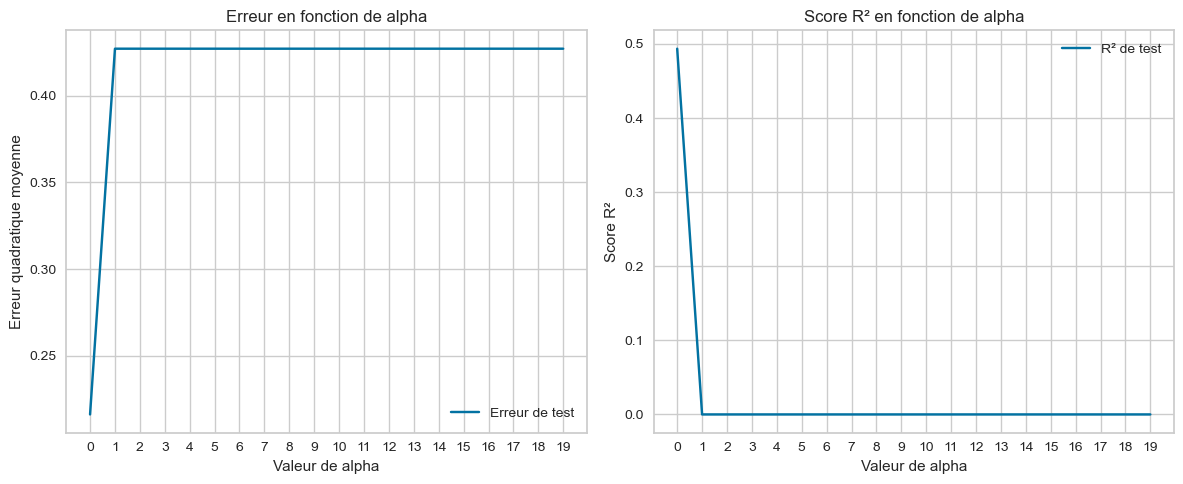

In [111]:
alpha_values = np.arange(0,20)
train_errors = []
test_errors = []
train_r2 = []
test_r2 = []

# Parcours des différentes valeurs de alpha
for alpha in alpha_values:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_std, y_train)
    
    # Calcul de l'erreur et du R2 pour les données de test
    y_test_pred = lasso.predict(X_test_std)
    test_errors.append(mean_squared_error(y_test, y_test_pred))
    test_r2.append(r2_score(y_test, y_test_pred))

# Création de la figure et des sous-graphiques
plt.figure(figsize=(12, 5))

# Graphique des erreurs
plt.subplot(1, 2, 1)
plt.plot(alpha_values, test_errors, label='Erreur de test')
plt.xlabel('Valeur de alpha')
plt.ylabel('Erreur quadratique moyenne')
plt.legend()
plt.xticks(alpha_values)  # Axe des abscisses avec les entiers 1 à 20
plt.title('Erreur en fonction de alpha')

# Graphique des scores R²
plt.subplot(1, 2, 2)
plt.plot(alpha_values, test_r2, label='R² de test')
plt.xlabel('Valeur de alpha')
plt.ylabel('Score R²')
plt.legend()
plt.grid(True)
plt.xticks(alpha_values)  # Axe des abscisses avec les entiers 1 à 20
plt.title('Score R² en fonction de alpha')

plt.tight_layout()
plt.show()

On observe avec les deux graphiques qu'au delà 1 pour alpha, le modèle de lasso donne des résultats plutôt médiocre.
Les meilleurs sont obtenus pour des valeurs de alpha proche de 0.
Nous allons effectuer une validation croisée sur des valeurs de alpha entre 0 et 1 et choisir celle qui donne l'erreur la plus faible.

In [112]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas=np.linspace(0.001, 1, 30), cv=5, random_state=42)  
# 30 valeurs d'alpha entre 0.001 et 1

# Entraînement du modèle
lasso_cv.fit(X_train_std, y_train)

# Meilleur alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha (avec validation croisée) : {best_alpha}")

# Performance du modèle avec le meilleur alpha
test_score = lasso_cv.score(X_test_std, y_test)
print(f"Score R² sur l'ensemble de test : {test_score}")

Best alpha (avec validation croisée) : 0.001
Score R² sur l'ensemble de test : 0.4934515473112978


Importance des variables

In [113]:
print(X_train.columns)
print("Linear model simple")
print("Coefficients:", lr.coef_)
print("Linear model lasso")
print("Coefficients:", lasso_cv.coef_)

Index(['diagonal', 'height_left', 'height_right', 'margin_up', 'length'], dtype='object')
Linear model simple
Coefficients: [-0.02645544  0.05304223  0.08501514  0.06652093 -0.3533451 ]
Linear model lasso
Coefficients: [-0.02550874  0.05238329  0.08442956  0.06603725 -0.35311942]


Contraiement au modèle de ridge, le modèle de lasso a donné plus d'importance aux variables 'diagonal' et 'length'. Les coefficients des variables 'height_left', 'height_right', 'margin_up' sont légèrement plus faibles par rapport au modèle de regression simple, ce qui signifie que ces variables sont un peu moins importante pour le modèle de lasso.

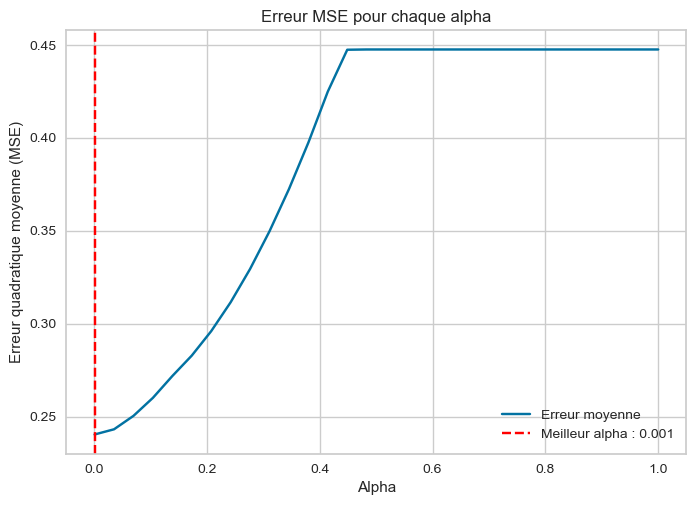

In [114]:
###Le graphe suivant nous permet de visualiser les erreurs lors du cross validation en fonction des valeurs de alpha
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), label="Erreur moyenne")
plt.xlabel("Alpha")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Erreur MSE pour chaque alpha")
plt.axvline(x=best_alpha, color='red', linestyle='--', label=f"Meilleur alpha : {best_alpha:.3f}")
plt.legend()
plt.show()


## Elastic-Net

In [14]:
from sklearn.linear_model import ElasticNet

In [18]:
elasticNet = linear_model.ElasticNet(fit_intercept=True, alpha=1,l1_ratio=.5)

# On entraîne ce modèle sur les données d'entrainement
elasticNet.fit(X_train_std, y_train)

# On récupère l'erreur de norme 2 sur le jeu de données test
elasticNet_error = mean_squared_error(y_test,elasticNet.predict(X_test_std))
score_test = r2_score(y_test,elasticNet.predict(X_test_std))


# On obtient l'erreur quadratique ci-dessous
print(elasticNet_error)
print(score_test)
print("Intercept:", elasticNet.intercept_)
print("Coefficients:", elasticNet.coef_)

0.42698000593598173
-3.515245461338523e-05
Intercept: 4.4848046875000005
Coefficients: [-0.  0.  0.  0. -0.]


C:\Users\user\AppData\Local\Temp\ipykernel_20544\471495669.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  elasticNet.fit(X_train_std, y_train)
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.210e+02, tolerance: 4.568e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(

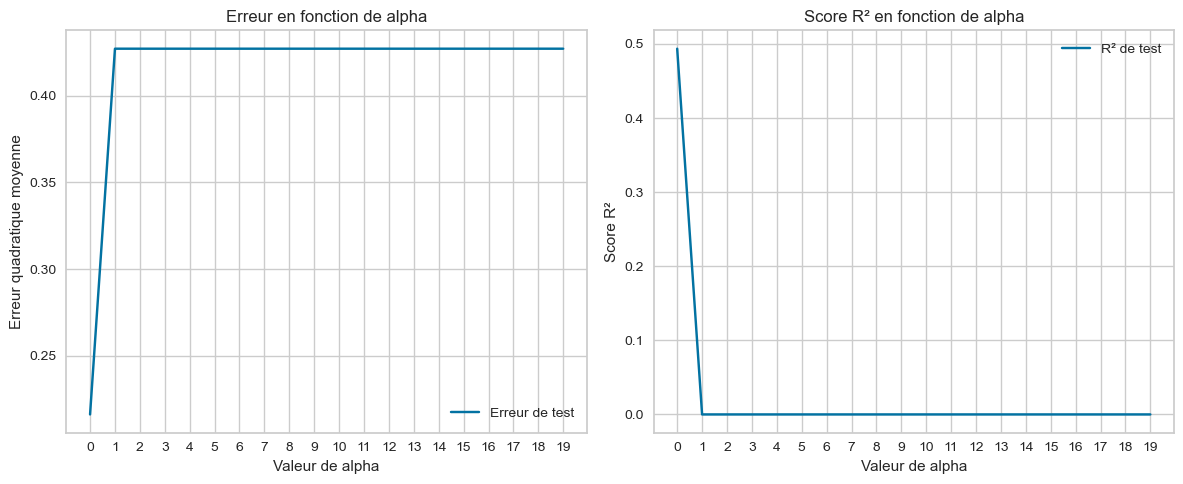

In [117]:
alpha_values = np.arange(0,20)
train_errors = []
test_errors = []
train_r2 = []
test_r2 = []

# Parcours des différentes valeurs de alpha
for alpha in alpha_values:
    elasticNet = ElasticNet(alpha=alpha)
    elasticNet.fit(X_train_std, y_train)
    
    # Calcul de l'erreur et du R2 pour les données de test
    y_test_pred = elasticNet.predict(X_test_std)
    test_errors.append(mean_squared_error(y_test, y_test_pred))
    test_r2.append(r2_score(y_test, y_test_pred))

# Création de la figure et des sous-graphiques
plt.figure(figsize=(12, 5))

# Graphique des erreurs
plt.subplot(1, 2, 1)
plt.plot(alpha_values, test_errors, label='Erreur de test')
plt.xlabel('Valeur de alpha')
plt.ylabel('Erreur quadratique moyenne')
plt.legend()
plt.xticks(alpha_values)  # Axe des abscisses avec les entiers 1 à 20
plt.title('Erreur en fonction de alpha')

# Graphique des scores R²
plt.subplot(1, 2, 2)
plt.plot(alpha_values, test_r2, label='R² de test')
plt.xlabel('Valeur de alpha')
plt.ylabel('Score R²')
plt.legend()
plt.grid(True)
plt.xticks(alpha_values)  # Axe des abscisses avec les entiers 1 à 20
plt.title('Score R² en fonction de alpha')

plt.tight_layout()
plt.show()

L'ElacticNet presente la même variable que le modèle de lasso.On observe avec les deux graphiques qu'au delà 1 pour alpha, le modèle donne des erreurs importantes.
Les meilleurs sont obtenus pour des valeurs de alpha proche de 0.
Nous allons effectuer une validation croisée sur des valeurs de alpha entre 0 et 1 et choisir celle qui donne l'erreur la plus faible.

In [118]:
from sklearn.linear_model import ElasticNetCV

elastic_net_cv = ElasticNetCV(cv=5, random_state=42)
elastic_net_cv.fit(X_train_std, y_train)
best_alpha = elastic_net_cv.alpha_
best_l1_ratio = elastic_net_cv.l1_ratio_

#l1_ratio= la proportion entre la régularisation L1 (Lasso) et L2 (Ridge) dans le modèle de régression
print(f"Meilleur alpha : {best_alpha}")
print(f"Meilleur l1_ratio : {best_l1_ratio}")
y_pred = elastic_net_cv.predict(X_test_std)
mse_test = mean_squared_error(y_test, y_pred)

# Afficher l'erreur de test
print(f"Erreur quadratique moyenne (MSE) sur l'ensemble de test : {mse_test:.4f}")

Meilleur alpha : 0.0009462198251237785
Meilleur l1_ratio : 0.5
Erreur quadratique moyenne (MSE) sur l'ensemble de test : 0.2163


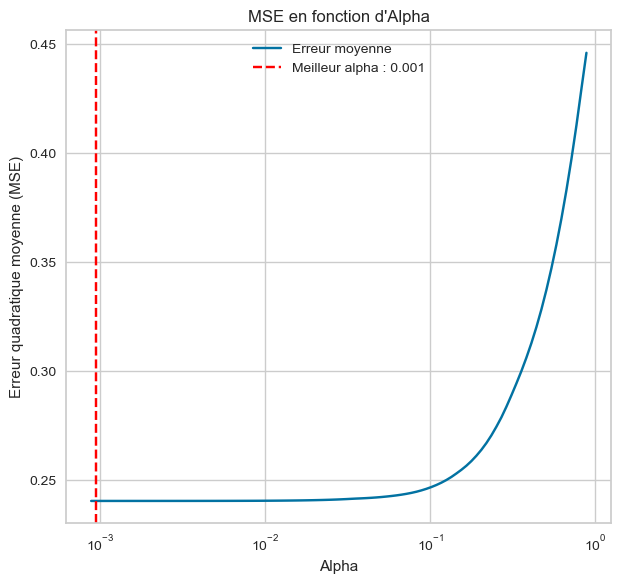

In [121]:
# Tracer les résultats pour alpha et l1_ratio
plt.figure(figsize=(12, 6))

# Tracer les valeurs alpha et la courbe de MSE
plt.subplot(1, 2, 1)
plt.plot(elastic_net_cv.alphas_, elastic_net_cv.mse_path_.mean(axis=1), label="Erreur moyenne")
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("MSE en fonction d'Alpha")
plt.axvline(x=best_alpha, color='red', linestyle='--', label=f"Meilleur alpha : {best_alpha:.3f}")
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()

Importance des variables

In [122]:
print(X_train.columns)
print("Linear model simple")
print("Coefficients:", lr.coef_)
print("Linear model lasso")
print("Coefficients:", elastic_net_cv.coef_)

Index(['diagonal', 'height_left', 'height_right', 'margin_up', 'length'], dtype='object')
Linear model simple
Coefficients: [-0.02645544  0.05304223  0.08501514  0.06652093 -0.3533451 ]
Linear model lasso
Coefficients: [-0.02600878  0.05275701  0.08475692  0.06636127 -0.35301827]


le modèle ElasticNet donne un peu plus d'importance aux variables 'diagonal' et 'length' par rapport à la regression simple. Tandis que que pour les autres variables, il leur donne une importance légèrement plus faible.